In [3]:
!pip install sklearn

In [1]:
import os
import numpy as np

## 데이터 확보

In [2]:
from pymongo import MongoClient
# from dotenv import load_dotenv

# load_dotenv(verbose=True,dotenv_path='./env')

# mongoDB 설정
mongo_host = "localhost"
mongo_port = 27020
mongo_user = "churros"
mongo_passwd = "A503"
mongo_db_name = "newsdb"
mongo_client = MongoClient(host=mongo_host, port=mongo_port, username=mongo_user, password=mongo_passwd)


db = mongo_client[mongo_db_name]
collection = db['newsCol']
tokencollection = db['newsToken'] # token collection

In [3]:
data = list(collection.find())
texts = list(i["full_text"] for i in data)

## gensim library 를 활용한 LDA

### 전처리

In [4]:
from konlpy.tag import  Komoran, Okt, Hannanum
# 형태소 분석 library import, jvm 필요
kom = Komoran()
okt = Okt()
han = Hannanum()
# komoran은 빈줄이 있으면 에러가 남
# komoran.morphs("\n".join([s for s in c[:40].split("\n") if s]))

In [5]:
# 중복 반복되는 단어 정규화
# from soynlp.normalizer import *
# repeat_normalize('와하하하하하하하하하핫', num_repeats=2)

In [6]:
# mecab = Mecab()
import re # 문자열 처리를 위한 정규표현식 패키지
from collections import Counter # 단어 등장 횟수 카운트
import pandas as pd

In [7]:
df_raw = pd.DataFrame(data)
df = df_raw.set_index("_idx")

In [8]:
# 분석에서 제외할 데이터 제거
df.reset_index(drop = True, inplace=True) # 인덱스 초기화

In [9]:
# 토큰화 이전 불필요한 글자들 전처리
# punctuation 삭제
PUNCTUATION = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
PUNCTUATION_MAPPING = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', } 
# 불필요한 부분 삭제(이메일, url등)
EMAIL_REGEX = re.compile(r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)')
URL_REGEX = re.compile(r'(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+')
HANGUL_REGEX = re.compile(r'[ㄱ-ㅎㅏ-ㅣ]+')
HTML_REGEX = re.compile(r'<[^>]*>')
PUNCTUATION_REGEX = re.compile(r'[^\w\s\n]')
def clean_str(text):
    # Replace punctuations using dictionary lookup
    for p in PUNCTUATION:
        text = text.replace(p, f' {p} ')

    for p in PUNCTUATION_MAPPING:
        text = text.replace(p, PUNCTUATION_MAPPING[p])
    
    # Use compiled regular expressions
    text = EMAIL_REGEX.sub('', text)
    text = URL_REGEX.sub('', text)
    text = HANGUL_REGEX.sub('', text)
    text = HTML_REGEX.sub('', text)
    text = PUNCTUATION_REGEX.sub('', text)
    
    # Replace newlines with periods
    text = text.replace('\n', '.')
    
    return text.strip() 

동사를 원형으로 복원하도록 하겠습니다. 규칙은 다음과 같습니다.

1. NNG|NNP|NNB + XSV|XSA --> NNG|NNP|NNB + XSV|XSA + 다
2. NNG|NNP|NNB + XSA + VX --> NNG|NNP + XSA + 다
3. VV --> VV + 다
4. VX --> VX + 다

In [10]:
# 동사 원형 복원
p1 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XS.')
p2 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XSA [가-힣A-Za-z0-9]+/VX')
p3 = re.compile('[가-힣A-Za-z0-9]+/VV')
p4 = re.compile('[가-힣A-Za-z0-9]+/VX')
def stemming_text(text):
    corpus = []
    for sent in text:
        ori_sent = sent
        mached_terms = re.findall(p1, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            modi_terms += '다/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        
        mached_terms = re.findall(p2, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                if tag != 'VX':
                    modi_terms += lemma
            modi_terms += '다/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p3, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p4, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        corpus.append((ori_sent))
    return corpus

In [107]:
## 임시 테스트 용 (전처리 속도 비교용)
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
def tokenstart(startidx, endidx):
    logging.info('Starting tokenwize')
    data = collection.find().skip(startidx).limit(endidx-startidx)
    data_list = list(data)
    df = pd.DataFrame(data_list)
    df["token"] = df["full_text"].apply(token)
    df_saving = df[["_idx", "token"]]
    records = df_saving.to_dict("records")
    logging.info('Ending tokenwize')
    return df_saving

def token(txt):
    okt = Okt()
    text = clean_str(txt)
    word_tokens = okt.pos(text, join="/", stem=True)
    stop_words_none = delete_stop_words(word_tokens)
    result = stemming_text(stop_words_none)
    return result
word_file = open("stopwords.txt", "r", encoding="utf-8")
words = word_file.read()
stop_words = set(words.split('\n'))
# lemmatization = {"VV","VX","NNG","NNP","NNB","XSV","XSA","SL","XR","SN","SH","SW","MAG","NF"}
lemmatization = {'Adjective', 'Adverb', 'Alpha', 'Exclamation', 'Foreign', 'Noun', 'Number',  'Unknown', 'Verb'} # 동사와 명사 형용사 및 기타 의미가 존재하는 형태소만을 남김
def delete_stop_words(text):
    result =  [word for word in text if (not (word.split('/')[0] in stop_words) and word.split('/')[1] in lemmatization)]
    return result


In [108]:
if "하다" in stop_words: print("true")

true


In [109]:
df = tokenstart(0, 350)

2023-03-27 12:01:13,630 - INFO - Starting tokenwize
2023-03-27 12:01:26,914 - INFO - Ending tokenwize


1. 바닐라 버전 : 10m 50.3s
2. punctuation 수정 버전 : 10m 7.5s
3. multiprocess 적용 버전 : 나가리
4. okt 모델 사용 : 30초
5. meccab 적용시켜보고는 싶다(이후에)

In [18]:
# 불용어 제거 및 특정 품사만 살리기
word_file = open("stopwords.txt", "r", encoding="utf-8")
words = word_file.read()
stop_words = set(words.split('\n'))
# 활용할 형태소 리스트
lemmatization = {"VV","VX","NNG","NNP","NNB","XSV","XSA","SL","XR","SN","SH","SW","MAG","NF"}

def token(txt):
    txt = clean_str(txt)
    word_tokens = kom.pos(txt, join="/")
    cleared = [word for word in word_tokens if (not (word.split('/')[0] in stop_words) and word.split('/')[1] in lemmatization)]
    result = stemming_text(cleared)
    return result
df["token"] = df["full_text"].apply(token)

In [ ]:
data = list(tokencollection.find())
df_token = pd.DataFrame(data)

KeyboardInterrupt: 

In [85]:
print(df.token.tail())

345    [반려견/Noun, 라이프/Noun, 스타일/Noun, 앱/Noun, 피리/Noun...
346    [디지털/Noun, 데/Noun, 일리/Noun, 왕진/Noun, 기자/Noun, ...
347    [14일/Number, 챔피언스/Noun, 미팅/Noun, 스콜피/Noun, 오배/...
348    [사진/Noun, IS/Alpha, 포토/Noun, 그야말로/Adverb, 논란/N...
349    [tvN/Alpha, 서울/Noun, 뉴스/Noun, 1/Number, 장/Noun...
Name: token, dtype: object


### Gensim corpora model
- 참고 [link](https://wikidocs.net/30708)

In [100]:
from gensim import corpora, models, similarities
dictionary = corpora.Dictionary(df.token)
dictionary.save('../pyrecommend-server/app/recommend_models/data/dictionary.pkl')
corpus = [dictionary.doc2bow(text) for text in df.token]
import pickle
with open('../pyrecommend-server/app/recommend_models/data/corpus.pkl', 'wb') as f:
    pickle.dump(corpus, f)


2023-03-27 11:57:45,252 - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2023-03-27 11:57:45,367 - INFO - built Dictionary<10979 unique tokens: ['10/Number', '10일/Number', '2023/Number', '3/Number', '77/Number']...> from 350 documents (total 80413 corpus positions)
2023-03-27 11:57:45,368 - INFO - Dictionary lifecycle event {'msg': "built Dictionary<10979 unique tokens: ['10/Number', '10일/Number', '2023/Number', '3/Number', '77/Number']...> from 350 documents (total 80413 corpus positions)", 'datetime': '2023-03-27T11:57:45.368980', 'gensim': '4.3.1', 'python': '3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}
2023-03-27 11:57:45,369 - INFO - Dictionary lifecycle event {'fname_or_handle': '../pyrecommend-server/app/recommend_models/data/dictionary.pkl', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-03-27T11:57:45.369983', 'gensim': '4.3.1'

In [101]:
print(corpus[1])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)]


In [102]:
print(dictionary[8])

yna/Alpha


In [103]:
len(dictionary) # 전체 활용하고 있는 단어 갯수

10979

In [104]:
import gensim
NUM_TOPICS = 30 # 30개의 토픽, k=20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

2023-03-27 11:57:47,162 - INFO - using symmetric alpha at 0.03333333333333333
2023-03-27 11:57:47,163 - INFO - using symmetric eta at 0.03333333333333333
2023-03-27 11:57:47,165 - INFO - using serial LDA version on this node
2023-03-27 11:57:47,216 - INFO - running online (multi-pass) LDA training, 30 topics, 15 passes over the supplied corpus of 350 documents, updating model once every 350 documents, evaluating perplexity every 350 documents, iterating 50x with a convergence threshold of 0.001000
2023-03-27 11:57:48,098 - INFO - -18.159 per-word bound, 292717.3 perplexity estimate based on a held-out corpus of 350 documents with 80413 words
2023-03-27 11:57:48,099 - INFO - PROGRESS: pass 0, at document #350/350
2023-03-27 11:57:48,602 - INFO - topic #4 (0.033): 0.006*"KT/Alpha" + 0.006*"고/Noun" + 0.005*"대표/Noun" + 0.004*"10일/Number" + 0.004*"받다/Verb" + 0.004*"대해/Noun" + 0.004*"대통령/Noun" + 0.004*"밝히다/Verb" + 0.004*"이다/Verb" + 0.004*"1/Number"
2023-03-27 11:57:48,603 - INFO - topic #13 

(3, '0.010*"2/Number" + 0.008*"1/Number" + 0.008*"PD/Alpha" + 0.007*"고/Noun"')
(19, '0.012*"버터/Noun" + 0.009*"코트/Noun" + 0.008*"콕스/Noun" + 0.008*"필러/Noun"')
(8, '0.012*"AI/Alpha" + 0.009*"수/Noun" + 0.009*"제공/Noun" + 0.009*"0/Number"')
(26, '0.023*"뉴시스/Noun" + 0.023*"사진/Noun" + 0.020*"해군/Noun" + 0.020*"대통령/Noun"')
(22, '0.027*"기자/Noun" + 0.021*"A/Alpha" + 0.015*"\xa0/Foreign" + 0.012*"사무실/Noun"')
(20, '0.027*"정부/Noun" + 0.021*"일본/Noun" + 0.014*"배상/Noun" + 0.014*"피해자/Noun"')
(18, '0.016*"산업/Noun" + 0.016*"이전/Noun" + 0.015*"은행/Noun" + 0.011*"부산/Noun"')
(11, '0.017*"안전/Noun" + 0.009*"진단/Noun" + 0.008*"수/Noun" + 0.008*"케이팝/Noun"')
(12, '0.010*"위/Noun" + 0.008*"대통령/Noun" + 0.007*"물류/Noun" + 0.007*"의원/Noun"')
(10, '0.027*"KT/Alpha" + 0.011*"늘다/Verb" + 0.009*"의혹/Noun" + 0.009*"관련/Noun"')
(24, '0.017*"금감원/Noun" + 0.012*"검사/Noun" + 0.009*"국민/Noun" + 0.008*"돼다/Verb"')
(25, '0.009*"한우/Noun" + 0.006*"로봇/Noun" + 0.006*"리비아/Noun" + 0.006*"수/Noun"')
(5, '0.009*"국회/Noun" + 0.009*"법/Noun" + 0.008*"단/Nou

In [105]:
print(ldamodel.print_topics())

2023-03-27 11:57:57,770 - INFO - topic #2 (0.033): 0.012*"신/Noun" + 0.007*"남태현/Noun" + 0.007*"늘다/Verb" + 0.007*"AI/Alpha" + 0.007*"수/Noun" + 0.006*"돼다/Verb" + 0.005*"사용/Noun" + 0.005*"고/Noun" + 0.005*"공개/Noun" + 0.005*"없다/Adjective"
2023-03-27 11:57:57,772 - INFO - topic #6 (0.033): 0.007*"늘다/Verb" + 0.006*"치료/Noun" + 0.006*"2/Number" + 0.006*"커피/Noun" + 0.005*"공개/Noun" + 0.005*"오다/Verb" + 0.004*"수/Noun" + 0.004*"전/Noun" + 0.004*"스윙/Noun" + 0.004*"테라/Noun"
2023-03-27 11:57:57,773 - INFO - topic #24 (0.033): 0.017*"금감원/Noun" + 0.012*"검사/Noun" + 0.009*"국민/Noun" + 0.008*"돼다/Verb" + 0.008*"선거/Noun" + 0.008*"LH/Alpha" + 0.007*"천/Noun" + 0.006*"획/Noun" + 0.006*"의원/Noun" + 0.006*"집/Noun"
2023-03-27 11:57:57,774 - INFO - topic #16 (0.033): 0.010*"대표/Noun" + 0.009*"화원/Noun" + 0.008*"비밀/Noun" + 0.007*"서울/Noun" + 0.007*"김해/Noun" + 0.007*"고/Noun" + 0.006*"기자/Noun" + 0.006*"힘/Noun" + 0.006*"국민/Noun" + 0.006*"말/Noun"
2023-03-27 11:57:57,775 - INFO - topic #15 (0.033): 0.010*"2/Number" + 0.008*"산책/No

[(2, '0.012*"신/Noun" + 0.007*"남태현/Noun" + 0.007*"늘다/Verb" + 0.007*"AI/Alpha" + 0.007*"수/Noun" + 0.006*"돼다/Verb" + 0.005*"사용/Noun" + 0.005*"고/Noun" + 0.005*"공개/Noun" + 0.005*"없다/Adjective"'), (6, '0.007*"늘다/Verb" + 0.006*"치료/Noun" + 0.006*"2/Number" + 0.006*"커피/Noun" + 0.005*"공개/Noun" + 0.005*"오다/Verb" + 0.004*"수/Noun" + 0.004*"전/Noun" + 0.004*"스윙/Noun" + 0.004*"테라/Noun"'), (24, '0.017*"금감원/Noun" + 0.012*"검사/Noun" + 0.009*"국민/Noun" + 0.008*"돼다/Verb" + 0.008*"선거/Noun" + 0.008*"LH/Alpha" + 0.007*"천/Noun" + 0.006*"획/Noun" + 0.006*"의원/Noun" + 0.006*"집/Noun"'), (16, '0.010*"대표/Noun" + 0.009*"화원/Noun" + 0.008*"비밀/Noun" + 0.007*"서울/Noun" + 0.007*"김해/Noun" + 0.007*"고/Noun" + 0.006*"기자/Noun" + 0.006*"힘/Noun" + 0.006*"국민/Noun" + 0.006*"말/Noun"'), (15, '0.010*"2/Number" + 0.008*"산책/Noun" + 0.006*"여자/Noun" + 0.006*"제안/Noun" + 0.006*"홀딩스/Noun" + 0.006*"분/Noun" + 0.006*"서울/Noun" + 0.006*"10일/Number" + 0.006*"1/Number" + 0.005*"KISCO/Alpha"'), (4, '0.011*"노총/Noun" + 0.011*"한국/Noun" + 0.009*"차트/Noun" +

In [106]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

c:\Coding\S08P22A503\venv\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\Coding\S08P22A503\venv\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### Optimal Topic Number Determining
- 참고 [link](https://humboldt-wi.github.io/blog/research/information_systems_1819/is_lda_final/)
- jaccard similarity를 측정하여 그룹 간의 차이점이 잘 구분되는 시점을 탐색

In [67]:
import random
topicnums = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70]
project_folder = os.getcwd()

ldamodels_bow = {}
for i in topicnums:
    random.seed(42)
    if not os.path.exists(project_folder+'\\models\\ldamodels_bow_'+str(i)+'.lda'):
        %time ldamodels_bow[i] = models.LdaModel(corpus, num_topics=i, random_state=42, update_every=1, passes=10, id2word=dictionary)
        ldamodels_bow[i].save(project_folder+'\\models\\ldamodels_bow_'+str(i)+'.lda')
        print('ldamodels_bow_{}.lda created.'.format(i))
    else: 
        print('ldamodels_bow_{}.lda already exists.'.format(i))

ldamodels_bow_1.lda already exists.
ldamodels_bow_5.lda already exists.
ldamodels_bow_10.lda already exists.
ldamodels_bow_15.lda already exists.
ldamodels_bow_20.lda already exists.
ldamodels_bow_25.lda already exists.
ldamodels_bow_30.lda already exists.
ldamodels_bow_35.lda already exists.
ldamodels_bow_40.lda already exists.
ldamodels_bow_45.lda already exists.
ldamodels_bow_50.lda already exists.
ldamodels_bow_55.lda already exists.
ldamodels_bow_60.lda already exists.
ldamodels_bow_65.lda already exists.
ldamodels_bow_70.lda already exists.


In [ ]:
lda_topics = {}
for i in topicnums:
    lda_model = models.LdaModel.load(project_folder+'/models/ldamodels_bow_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

In [ ]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return float(len(intersection))/float(len(union))

In [ ]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims

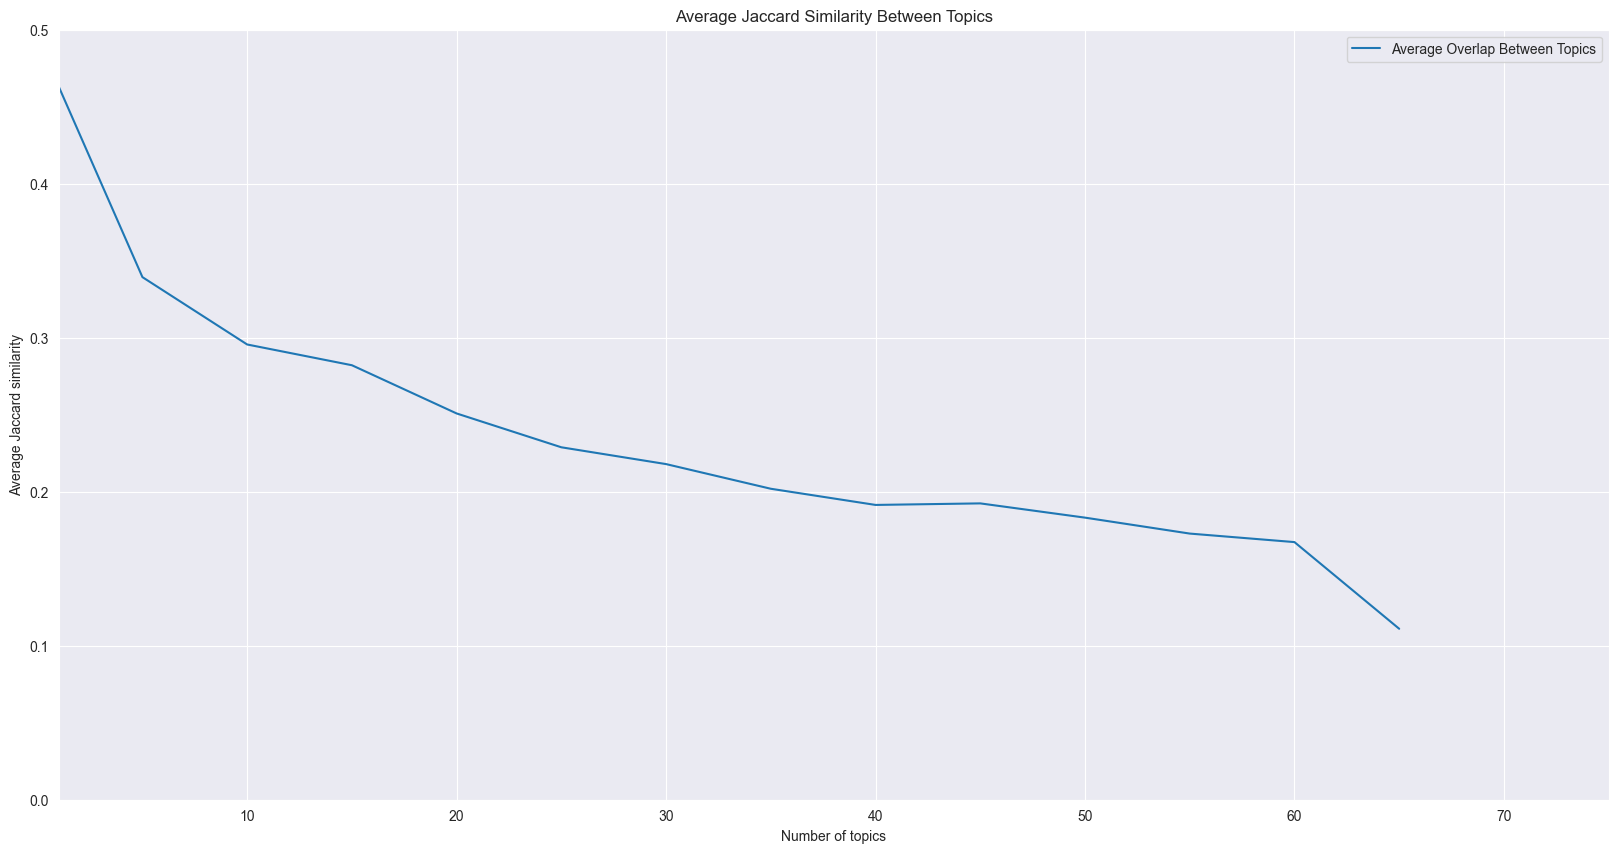

In [ ]:
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

import matplotlib.pyplot as plt
import seaborn as sns

with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.figure(figsize=(20,10))
    plt.plot(x,y,label='Average Overlap Between Topics')
    plt.xlim([1, 75])
    plt.ylim([0, 0.5])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')   
    plt.title('Average Jaccard Similarity Between Topics')
    plt.legend()    
    plt.show()

### 추천 진행

In [ ]:
num_topics = 65
lda_model_final = models.LdaModel.load(project_folder+'/models/ldamodels_bow_'+str(num_topics)+'.lda')
lda_model_final.save('../pyrecommend-server/app/recommend_models/data/ldamodels.lda')
corpus_lda_model = lda_model_final[corpus]

In [ ]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_final, corpus, dictionary)
pyLDAvis.display(vis)

In [ ]:
# %%cache mycache_lda_index.pkl index
index = similarities.MatrixSimilarity(lda_model_final[corpus])
index.save('../pyrecommend-server/app/recommend_models/data/ldaindex.sim')

In [ ]:
def book_recommender(idx):
    books_checked = 0
    for i in range(len(df.token)):
        recommendation_scores = []
        if i == idx:
            lda_vectors = corpus_lda_model[i]
            print("아마도 한개의 벡터",lda_vectors)
            sims = index[lda_vectors]
            sims = list(enumerate(sims))
            for sim in sims:
                book_num = sim[0]
                recommendation_score = [df.title[book_num], sim[1],df.index[book_num],]
                recommendation_scores.append(recommendation_score)
            
            recommendation = sorted(recommendation_scores, key=lambda x: x[1], reverse=True)
            print("Your article's most prominent tokens are:")
            article_tokens = corpus[i]
            sorted_tokens = sorted(article_tokens, key=lambda x: x[1], reverse=True)
            sorted_tokens_10 = sorted_tokens[:10]
            for i in range(len(sorted_tokens_10)):
                print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens_10[i][0], 
                                                             dictionary[sorted_tokens_10[i][0]], 
                                                             sorted_tokens_10[i][1]))
            print('-----')
            print("Your article's most prominant topic is:")
            print(lda_model_final.print_topic(max(lda_vectors, key=lambda item: item[1])[0]))
            print('-----')
            print('Here are your recommendations for "{}":'.format(idx))
            display(recommendation[1:11])
        
        else:
            books_checked +=1
            

In [ ]:
book_recommender(300)

아마도 한개의 벡터 [(3, 0.018066522), (7, 0.015421404), (8, 0.013928107), (11, 0.011017182), (13, 0.034080453), (16, 0.030304482), (17, 0.04870288), (18, 0.010740764), (19, 0.022649288), (20, 0.05720388), (21, 0.034914885), (25, 0.015919918), (26, 0.11127497), (27, 0.120525055), (29, 0.019740786), (31, 0.019266121), (32, 0.038871426), (34, 0.011417946), (39, 0.030440694), (40, 0.02114665), (42, 0.033394195), (46, 0.026531437), (48, 0.059319098), (49, 0.011249074), (52, 0.022213107), (55, 0.040710937), (58, 0.036763914), (61, 0.0153145455), (64, 0.016289825)]
Your article's most prominent tokens are:
Word 10303 ("아이파크몰/NNP") appears 9 time(s).
Word 592 ("점/NNB") appears 8 time(s).
Word 10306 ("척/NNP") appears 8 time(s).
Word 1280 ("지역/NNG") appears 6 time(s).
Word 10280 ("개점/NNG") appears 5 time(s).
Word 10282 ("구로구/NNP") appears 5 time(s).
Word 769 ("식/NNB") appears 4 time(s).
Word 1225 ("동/NNP") appears 4 time(s).
Word 10278 ("HDC/SL") appears 4 time(s).
Word 0 ("10/SN") appears 3 time(s).
--

[['"서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아', 1.0, 1626],
 ['"서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아', 0.99999994, 1290],
 ['아이파크몰 고척점, 누적 방문객수 170만 명 돌파', 0.86939687, 5225],
 ['누구나 부모가 되지만, 아무나 부모가 될 수 없다', 0.83780134, 4949],
 ['누구나 부모가 되지만, 아무나 부모가 될 수 없다', 0.83766943, 5250],
 ["검찰, 'JMS 성폭행' 증인 출석 대비 피해자 보호 방안 논의", 0.8252579, 26779],
 ['법원장까지 재판…“제주에 판사가 없다”', 0.8204434, 25253],
 ['법원장까지 재판…“제주에 판사가 없다”', 0.82042855, 25235],
 ['법원장까지 재판…“제주에 판사가 없다”', 0.8204263, 27084],
 ['[단독]행안부 문경시 인근 상주추모공원건립 재검토 판정. 사업수정 불가피', 0.8092396, 24136]]

### 유저 경험 기반, 평균값으로 하는 추천

In [ ]:
def user_recommender(user_history):
    # Compute the user's average topic distribution
    user_topics = np.zeros(num_topics)
    for i in user_history:
        single_corpus = corpus_lda_model[i]
        for word in single_corpus:
            user_topics[word[0]] += word[1]
    user_average = user_topics / len(user_history)
    # Compute similarity scores between user history mean and all articles in corpus
    sims = index[user_average]
    # Create list of tuples with article index and similarity score
    sim_scores = list(enumerate(sims))

    # Sort list of tuples in descending order based on similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Select top N articles with highest similarity scores
    N = 5
    top_n_indices = [i[0] for i in sim_scores[0:N+1]]
    print(top_n_indices)
    # Retrieve titles of recommended articles
    recommendations = df.loc[top_n_indices, "title"].tolist()
    print(f"Top {N} recommended articles based on user history:")
    print(recommendations)


In [ ]:
df_raw.iloc[1290]

_id                                      640aee622ad8d98d1d504d4d
_idx                                                          878
cat1                                                           경제
cat2                                                         생활경제
title                     "서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아
description     기사내용 요약 10일 공식 개점식 열어 HDC그룹 계열사 내 유통 전문 기업인 HD...
press                                                         뉴시스
link            https://n.news.naver.com/mnews/article/003/001...
publish_date                                  2023-03-10 17:30:11
full_text       기사내용 요약10일 공식 개점식 열어\n\n\n\n10일, 아이파크몰 고척점 개점식...
img_src         https://imgnews.pstatic.net/image/003/2023/03/...
Name: 1290, dtype: object

In [ ]:
df.loc[1290]

_id                                      640aee622ad8d98d1d504d4d
cat1                                                           경제
cat2                                                         생활경제
title                     "서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아
description     기사내용 요약 10일 공식 개점식 열어 HDC그룹 계열사 내 유통 전문 기업인 HD...
press                                                         뉴시스
link            https://n.news.naver.com/mnews/article/003/001...
publish_date                                  2023-03-10 17:30:11
full_text       기사내용 요약10일 공식 개점식 열어\n\n\n\n10일, 아이파크몰 고척점 개점식...
img_src         https://imgnews.pstatic.net/image/003/2023/03/...
token           [기사/NNG, 내용/NNG, 요약/NNG, 10/SN, 공식/NNG, 개점/NNG...
Name: 1290, dtype: object

In [ ]:
user_history = [300]
user_recommender(user_history)

[1290, 300, 1626, 5225, 4949, 5250]
Top 5 recommended articles based on user history:
['"서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아', '"서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아', '"서남권 쇼핑 중심지로" 고척 아이파크몰, 오픈 두달만 170만명 찾아', '아이파크몰 고척점, 누적 방문객수 170만 명 돌파', '누구나 부모가 되지만, 아무나 부모가 될 수 없다', '누구나 부모가 되지만, 아무나 부모가 될 수 없다']


### 유저 경험 기반 시간대 별로 weight 주기